# Importation des données

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, to_tree, cut_tree
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import confusion_matrix
from sklearn import metrics # for evaluations
from sklearn.datasets import make_blobs, make_circles # for generating experimental data
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
data = pd.read_csv("data/data.csv.gz", compression = 'gzip')

# Clustering 

## CAH sur toutes les données

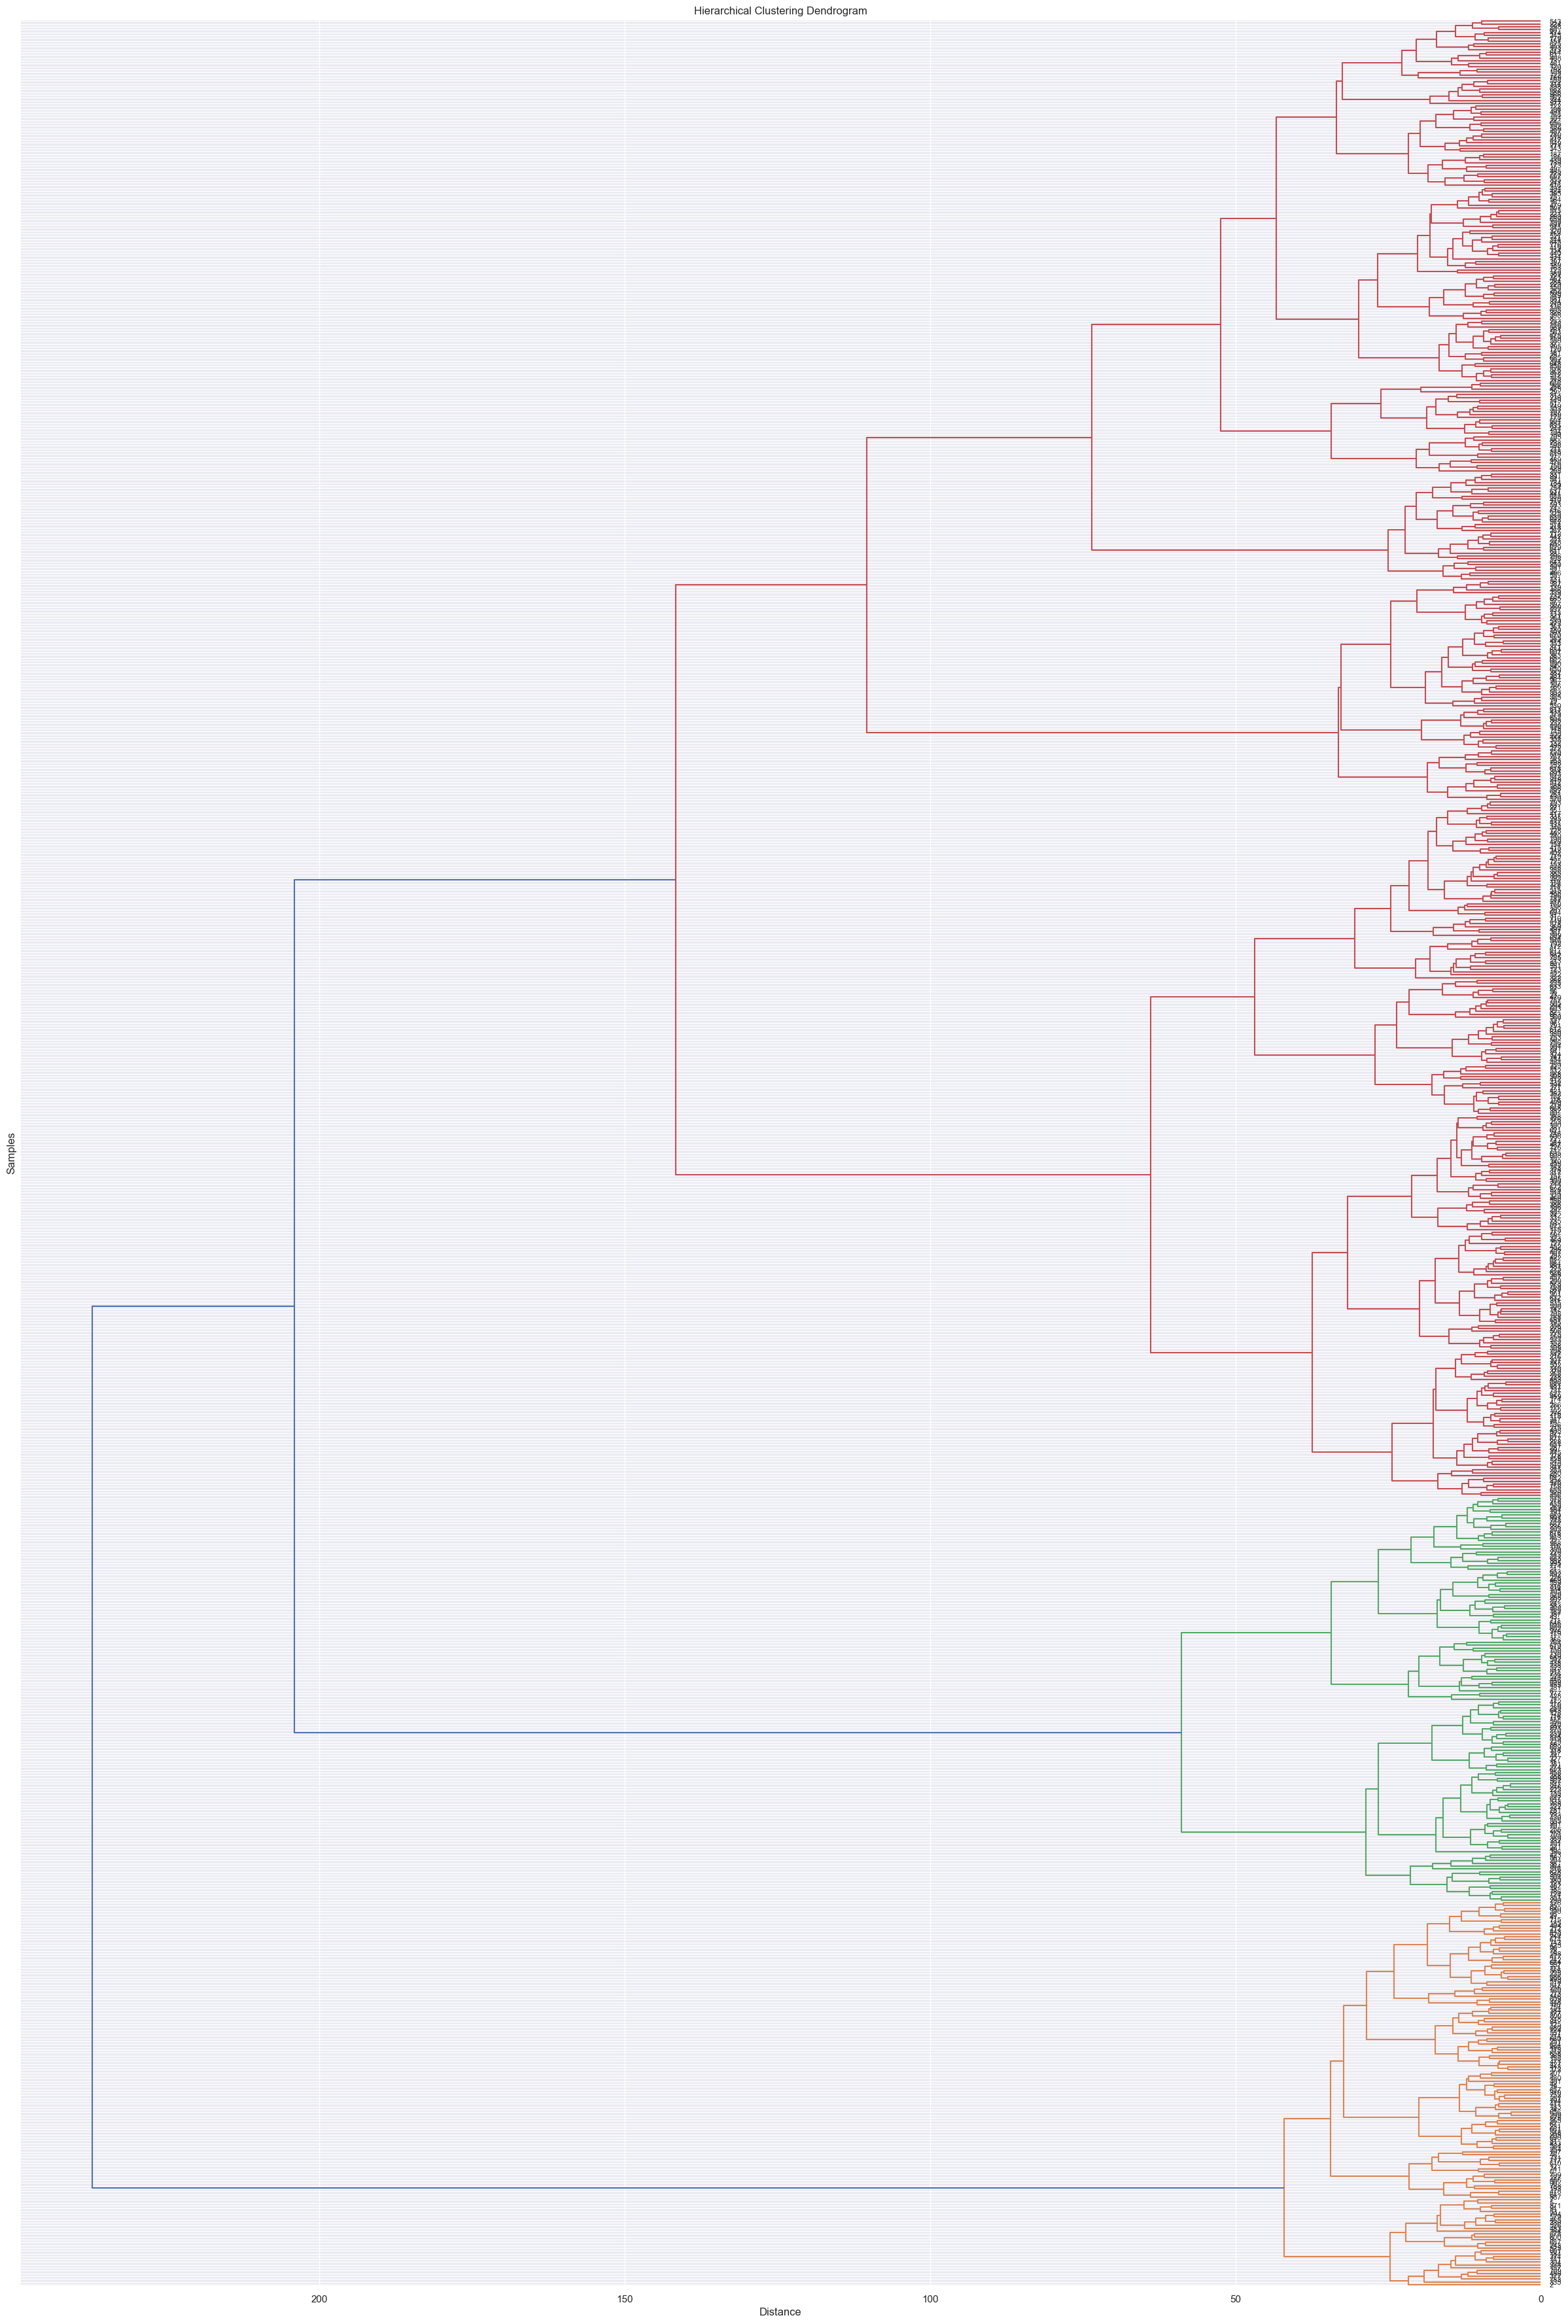

In [16]:
#On copie le DF :
data2 = data.drop(columns=['Unnamed: 0', 'Class'])

distance_matrix = squareform(pdist(data2, metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(data2, method='ward')

# Plot the dendrogram
plt.figure(figsize=(30, 45))
dendrogram(linkage_matrix,
           orientation="left",
           labels=data.index.tolist(),
           leaf_font_size=8)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Samples')
plt.xlabel('Distance')
plt.show()

On sélectionne les variables qui ont une "grande" variance uniquement, histoire d'en garder 3 500.

In [51]:
import pandas as pd

# Calculer la variance des colonnes
variances = data.drop(columns=['Unnamed: 0']).var(axis=0)

# Filtrer les gènes avec un seuil (ex: 0.01)
df_filtré = data.drop(columns=['Unnamed: 0']).loc[:, variances > 3]

df_filtré.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 3531 entries, gene_18 to gene_20529
dtypes: float64(3531)
memory usage: 21.6 MB


In [32]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Supposons que df soit un DataFrame avec (801, N) où N est le nombre de gènes après filtrage
df = pd.DataFrame(df_filtré)  # Convertir en DataFrame si nécessaire

# Appliquer le StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Convertir en DataFrame si besoin
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)

# Vérification : moyenne proche de 0 et écart-type proche de 1
print("Moyennes après scaling:", df_scaled.mean().mean())  # Devrait être proche de 0
print("Écart-types après scaling:", df_scaled.std().mean())  # Devrait être proche de 1


Moyennes après scaling: -3.7948854334468506e-18
Écart-types après scaling: 1.0006248048094746


## CAH sur les données filtrées

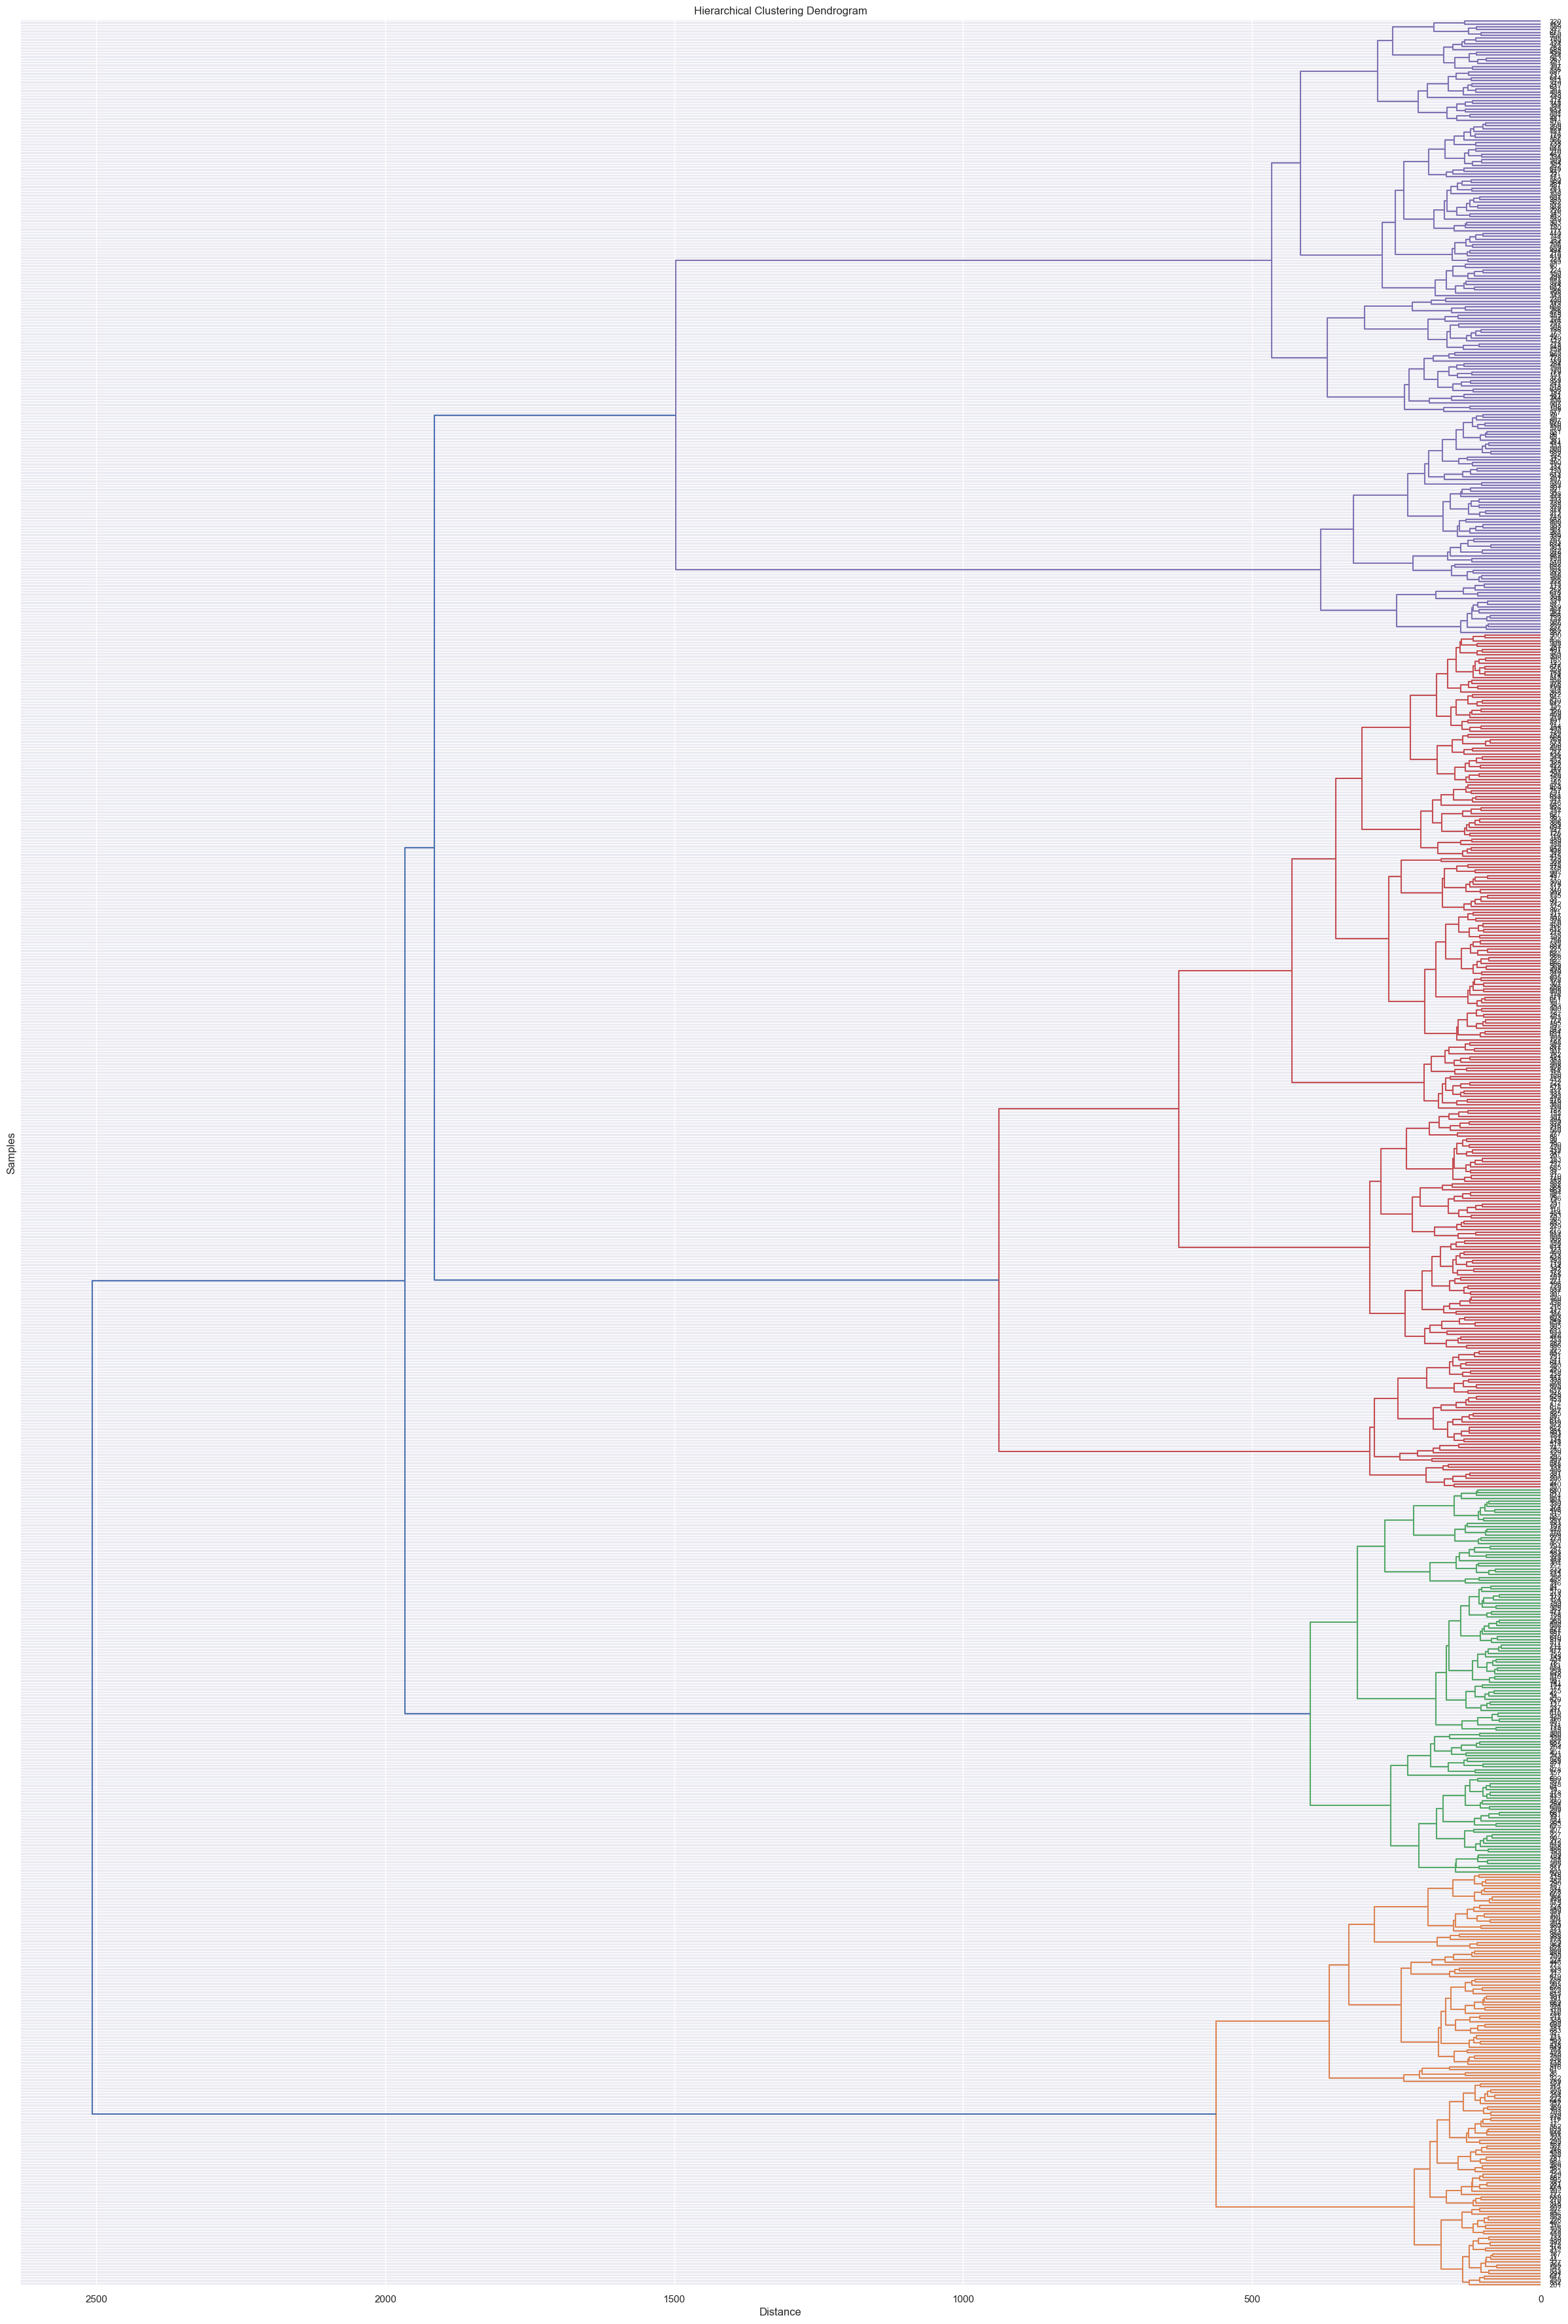

In [35]:
#On copie le DF :
data2 = df_filtré.copy()

distance_matrix = squareform(pdist(data2, metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(data2, method='ward')

# Plot the dendrogram
plt.figure(figsize=(30, 45))
dendrogram(linkage_matrix,
           orientation="left",
           labels=data.index.tolist(),
           leaf_font_size=8)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Samples')
plt.xlabel('Distance')
plt.show()

## CAH sur les données filtrées + centrées réduites

In [ ]:
#On copie le DF :
data2 = df_scaled.copy()

distance_matrix = squareform(pdist(data2, metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(data2, method='ward')

# Plot the dendrogram
plt.figure(figsize=(30, 45))
dendrogram(linkage_matrix,
           orientation="left",
           labels=data.index.tolist(),
           leaf_font_size=8)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Samples')
plt.xlabel('Distance')
plt.show()

# CAH sur les axes d'ACP

## On refait l'ACP :

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [43]:
# Standardisation des donnees
scale = StandardScaler()
df_filtré_2 = scale.fit_transform(df_filtré)

df_filtré_2 = pd.DataFrame(df_filtré_2, columns=df_filtré.columns)

# Réalisation de l'ACP
pca = PCA()
pca.fit(df_filtré_2)
components = pca.fit_transform(df_filtré_2)

## On fait la CAH

Comment savoir combien d'axes on garde pour la CAH ? On fait le graphe d'inertie.

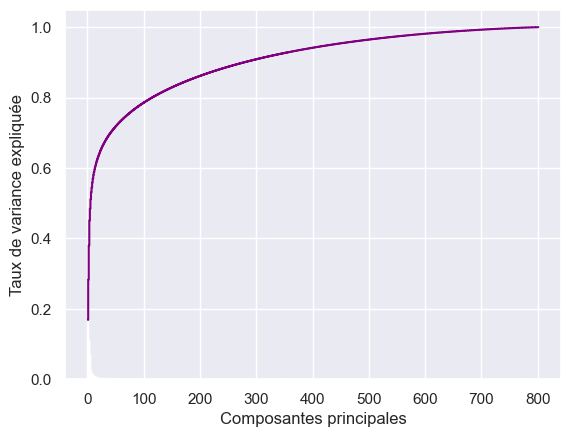

In [44]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=1, align='center')
plt.step(range(1,len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid', color='purple')

# Ajout des légendes
plt.ylabel('Taux de variance expliquée') #violet : Variance expliquée cumulée
plt.xlabel('Composantes principales')
plt.show()

Allez, on garde les 100 premiers axes (environ 80% d'inertie restituée).

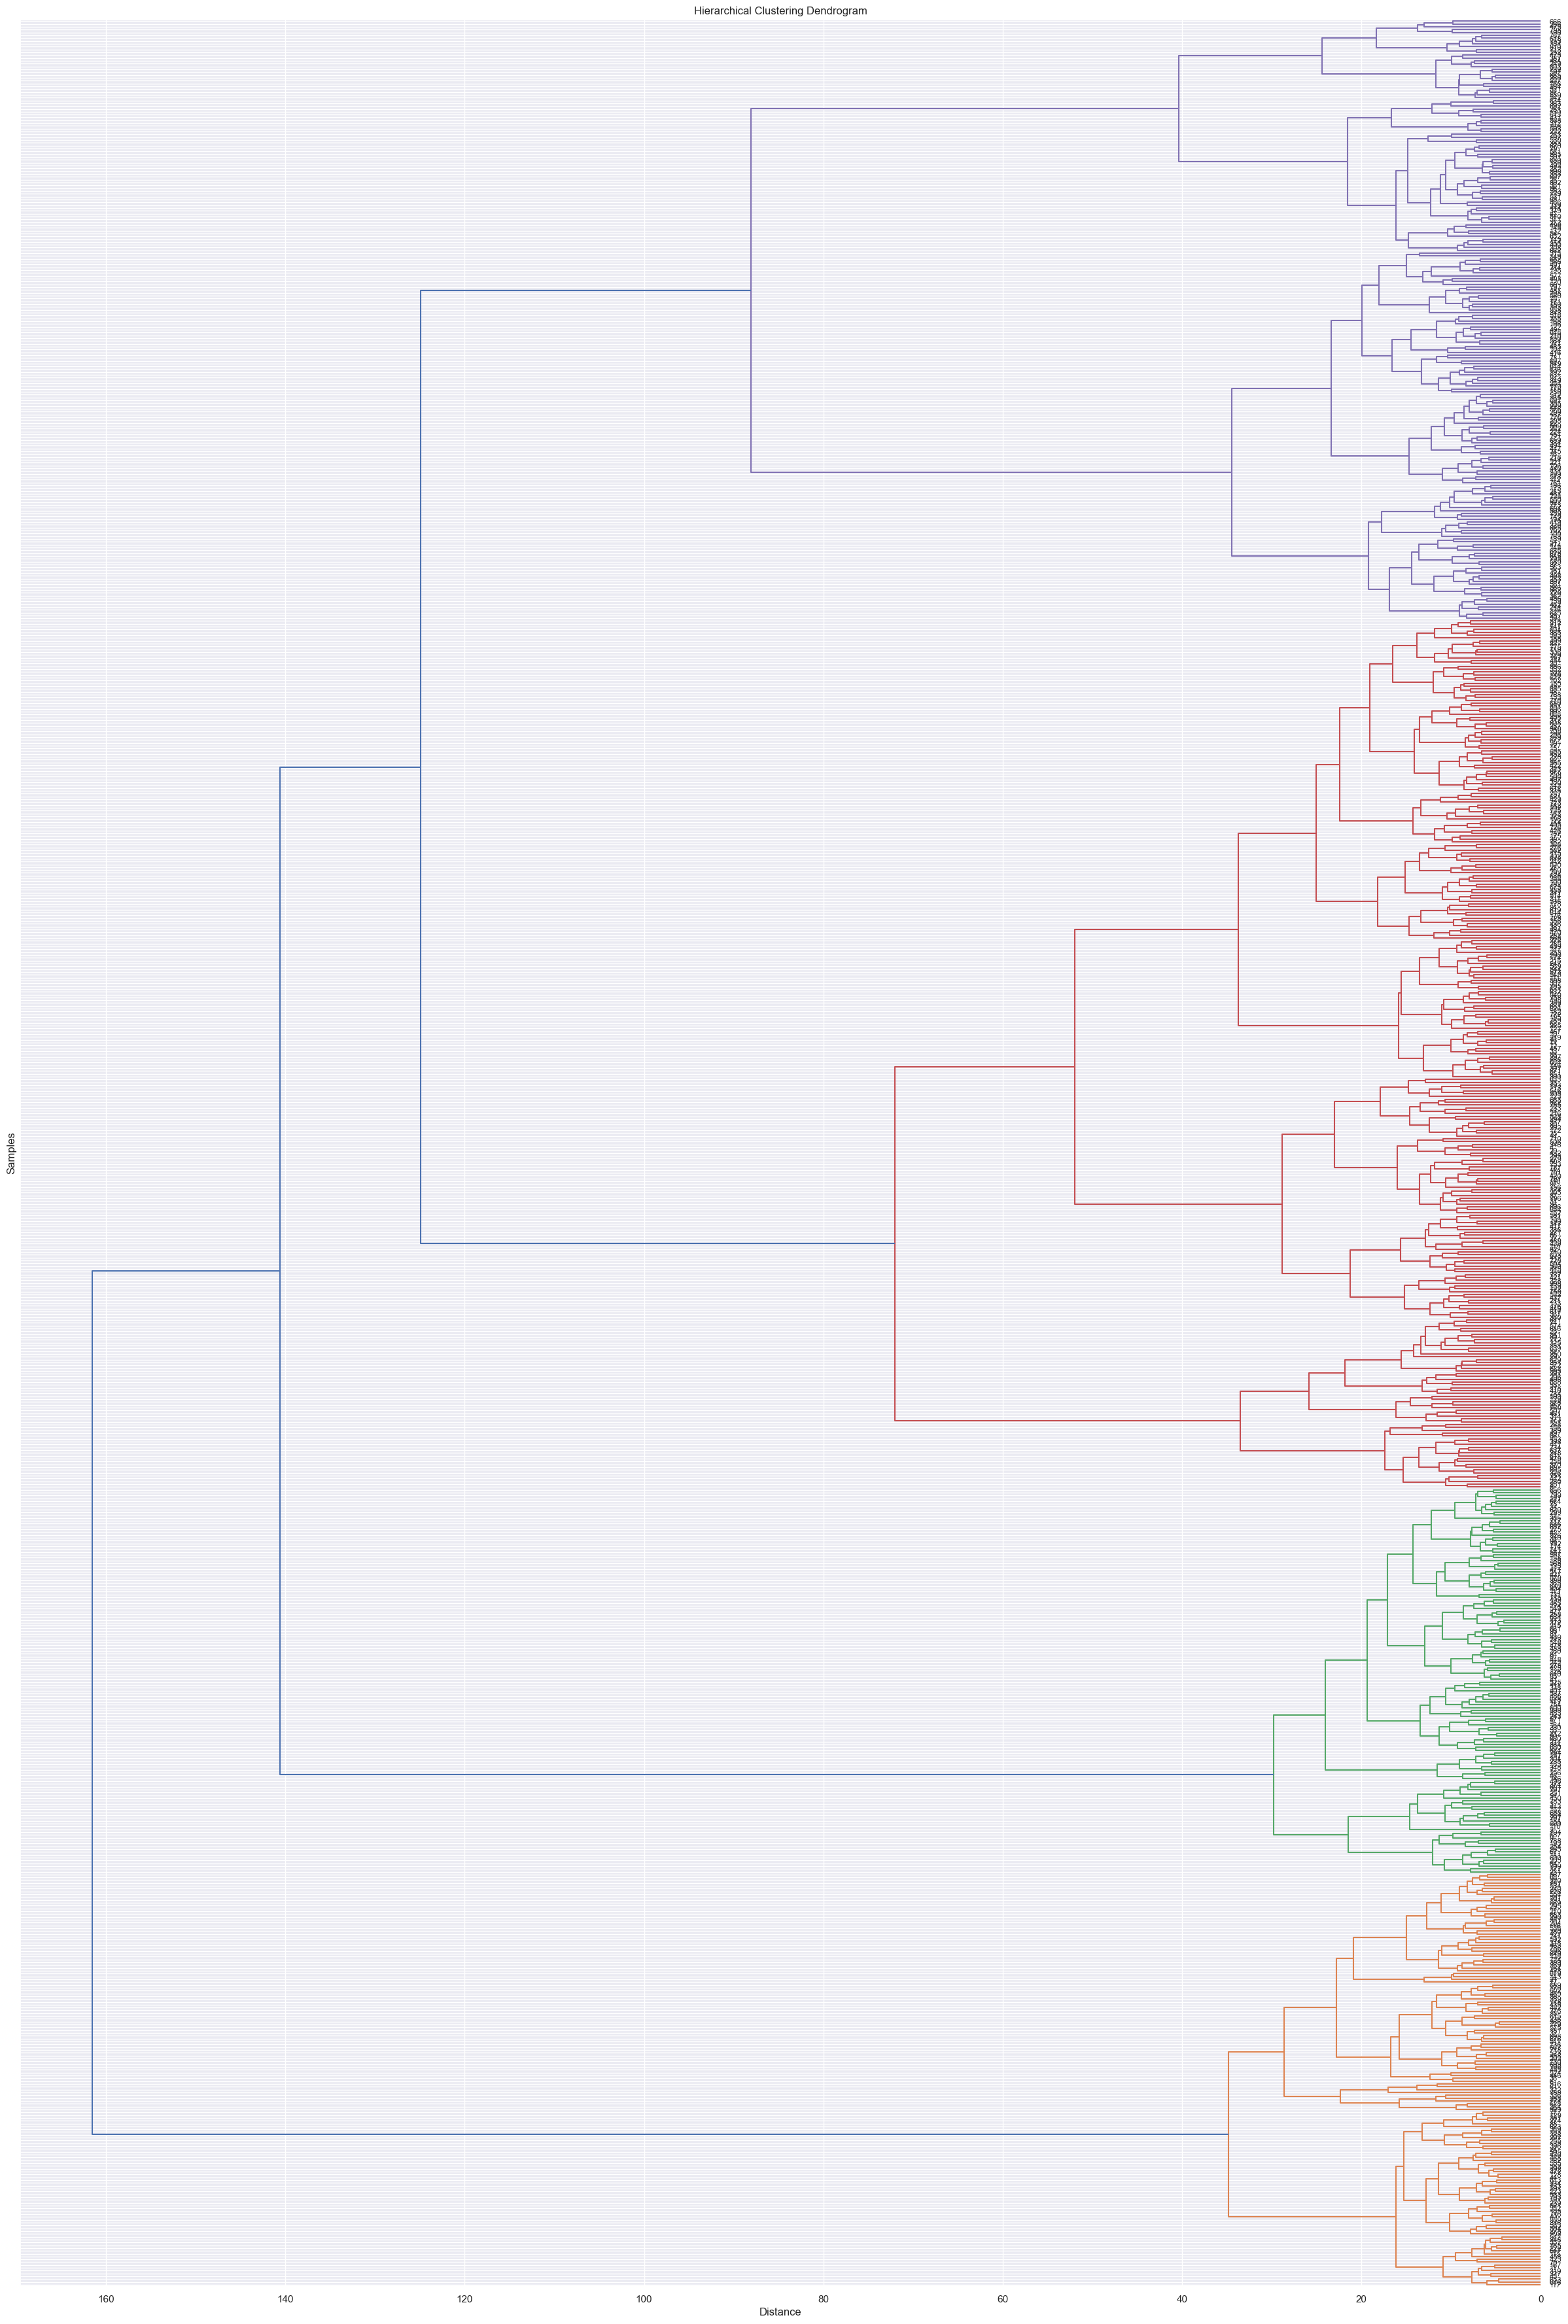

In [52]:
#On copie le DF :
data2 = df_filtré_2.iloc[:, :100].copy()  # Garder les 100 premières variables

distance_matrix = squareform(pdist(data2, metric='euclidean'))

# Perform hierarchical clustering
linkage_matrix = linkage(data2, method='ward')

# Plot the dendrogram
plt.figure(figsize=(30, 45))
dendrogram(linkage_matrix,
           orientation="left",
           labels=data.index.tolist(),
           leaf_font_size=8)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Samples')
plt.xlabel('Distance')
plt.show()

Qu'est-ce qu'on remarque ? On a toujours globalement 6 classes qui se démarquent lorsque l'on souhaite se situer entre 20 et 60 de distance. 
C'est un peu embêtant étant donnée que l'on travaille sur 5 types de cancers différents. 

Ce qu'il faut faire pour continuer le travail : <br>
    - Regarder plus en profondeur les classes qui ont été formées (on va en choisir 6) via nos CAH et les comparer avec les vrais labels.  
    - En déduire comment les cancers sont "classés" : pourquoi une nouvelle classe se forme ? Peut-être que deux cancers sont extrêmement proches et en créent une nouvelle classe ? Peut-être que cela arrive sur plusieurs cancers et d'autres, quant à eux, s'insérent dans toutes les classes ? Si oui, c'est gênant. Il y aura peut-être un changement d'objectif à faire sur ce point...

## Comparer les classes formées et les vraies classes

In [93]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster

data2 = df_filtré_2.iloc[:, :100].copy()  # Garder les 100 premières variables

# Standardisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data2)

# Clustering hiérarchique avec la méthode de Ward
linkage_matrix = linkage(data_scaled, method='ward')

# Créer les classes en fonction d'un seuil de distance (ici 60)
clusters = fcluster(linkage_matrix, t=80, criterion='distance')  # t=80 pour couper à 60 de distance

# print("Clusters à 60 de distance:", clusters)

# Vérification du nombre de clusters
print("Nombre de clusters à 80:", len(np.unique(clusters)))


Nombre de clusters à 80: 5


3    307
1    146
2    136
4    130
5     82
Name: count, dtype: int64


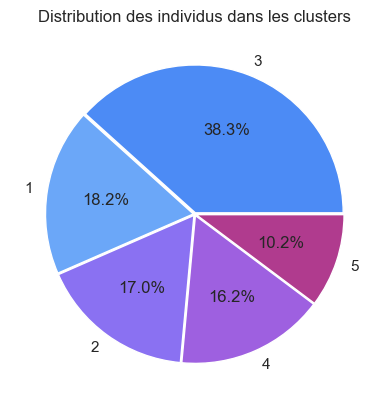

In [94]:
# Comptons le nombre d'individus dans chaque cluster
class_counts = pd.Series(clusters).value_counts()
print(class_counts)

# Création du pie chart
colors = ['#4C8BF5', '#6BA7F8', '#8A71F2', '#9E60E0', '#B03B8E', '#F5804C']  
explode = (0.01,) * len(class_counts)  # Exploser chaque secteur un peu

plt.pie(class_counts, labels=class_counts.index.astype(str), autopct='%1.1f%%', colors=colors, explode=explode)
plt.title("Distribution des individus dans les clusters")
plt.show()

Maintenant il faudrait voir de quoi sont constitués ces clusters. Comparons les avec les vrais labels ! Pour cela, on utilise le dataframe labels (consistué de la variable 'Class').

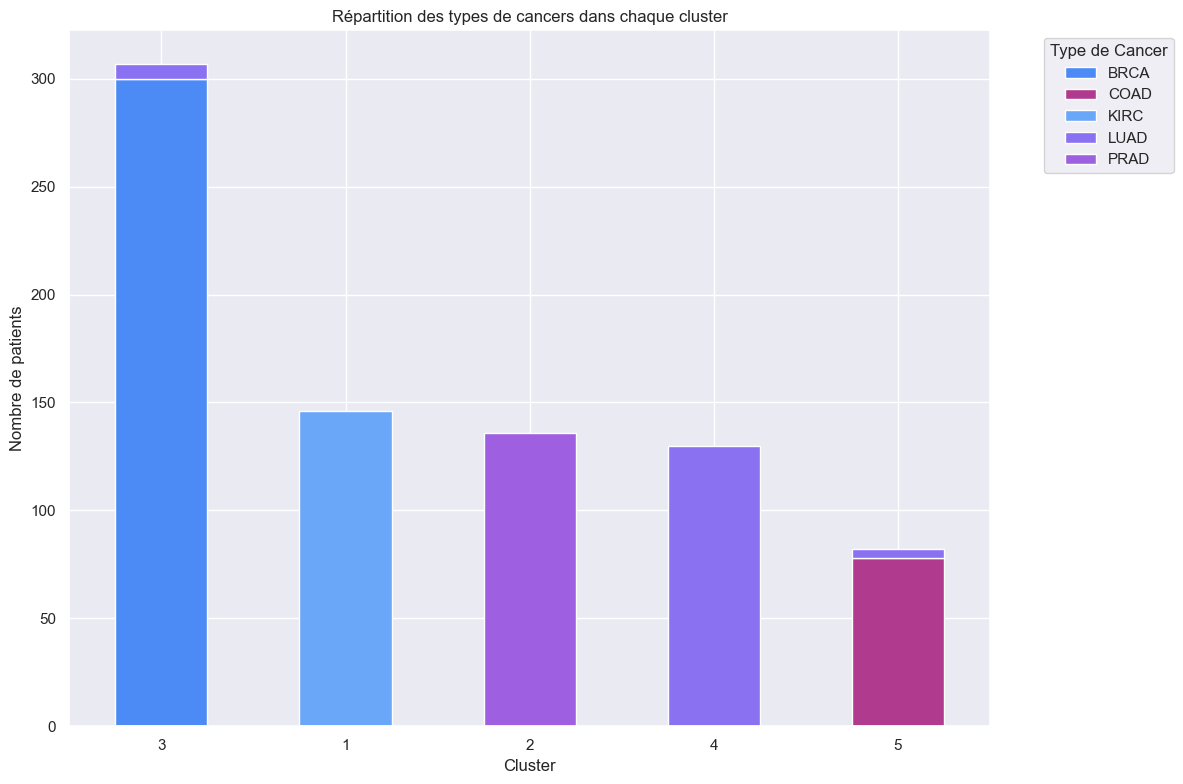

In [100]:
labels = pd.read_csv('data/labels.csv')

# Ajouter les clusters au DataFrame des labels
labels['Clusters'] = clusters

# Compter le nombre de patients de chaque type de cancer dans chaque cluster
cluster_counts = labels.groupby(['Clusters', 'Class']).size().unstack(fill_value=0)

# Trier les clusters en fonction de la fréquence totale des patients dans chaque cluster
cluster_counts = cluster_counts.loc[cluster_counts.sum(axis=1).sort_values(ascending=False).index]

# Visualiser les résultats avec un barplot en utilisant les couleurs personnalisées
colors = ['#4C8BF5', '#B03B8E', '#6BA7F8', '#8A71F2', '#9E60E0']

cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)

plt.title('Répartition des types de cancers dans chaque cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=0)
plt.legend(title='Type de Cancer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Résultat très satisfaisant. On va mettre des chiffres sur ce graphe : 

In [101]:
from sklearn.metrics import adjusted_rand_score

# Calcul de l'Adjusted Rand Index (ARI)
ari = adjusted_rand_score(labels['Class'], clusters)
print(f"Adjusted Rand Index: {ari}")

Adjusted Rand Index: 0.9672000450526909


Un Adjusted Rand Index (ARI) de 0.967 indique une très forte similarité entre les clusters créés par la CAH et les vrais labels de cancer. En effet, un ARI proche de 1 signifie que les partitions (les clusters) correspondent bien aux vrais labels, ce qui est un excellent résultat.